# First Notes

Please do not run the file as whole, as some cells include some alternative overwriting code that was created for tyring out different parameter values, testing some examples and experimenting. The cells that are noted by a **BEGIN:** and **END;** notations can be ignored.

First, let's go through the imports we'll need for this session. I’ll need RDkit for molecular conversion and fingerprints calculation, numpy for linear algebra computations, Scikit-learn for standardisation, data set splitting  model metrics. And lastly Keras for the neural network training.

# Reading data

Reading a set of molecules an `SDMolSupplier` from `rdkit`. The supplier is the set of the molecules put together as a set.<br>
In the [getting started](https://www.rdkit.org/docs/GettingStartedInPython.html) documentation there're two these two different suppliers:
* `rdkit.Chem.rdmolfiles.SDMolSupplier`
* `rdkit.Chem.rdmolfiles.SmilesMolSupplier`

We're gonna be using the `SDMolSupplier`.<br>

The file `cas_4337.sdf` can be found the data/ directory. The dataset includes $4337$ molecular structures that were approved by the Ames test. Read Data Preprocessing section from the [project report](doc/project_report.pdf).

In [2]:
from rdkit import Chem
## Read the file
supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
len(supplier)

4337

We have $4337$ molecules in the data set:
A good practice is to test each molecule to see if it was correctly read before working with it. If the output is an empty list then the data is fine.

In [3]:
corrupted_mols = [mol for mol in supplier if mol is None]
corrupted_mols

[]

## Visualizing the Data

Let's visualize the data. Usually we would plot the distributions and a summary of the data variables, but here we have only molecular structures, so let's plot the first 50 molecules.

Press <kbd>⇧</kbd><kbd>O</kbd> *to change to toggle full output.*

Index: 1
Name: 1728-95-6


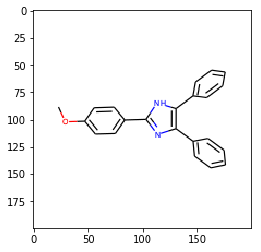

Index: 2
Name: 91-08-7


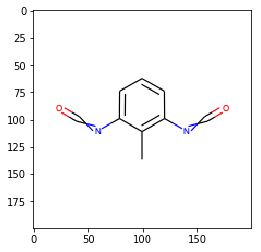

Index: 3
Name: 89786-04-9


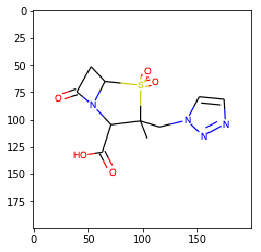

Index: 4
Name: 2439-35-2


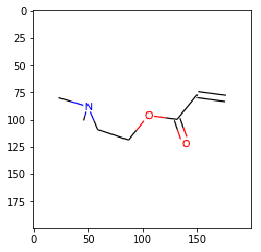

Index: 5
Name: 95-94-3


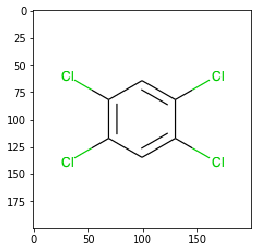

Index: 6
Name: 120314-14-9


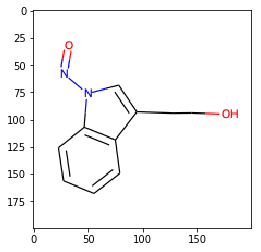

Index: 7
Name: 146795-42-8


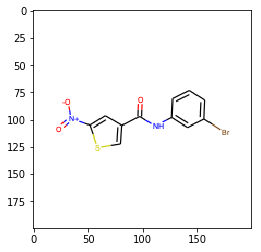

Index: 8
Name: 119-41-5


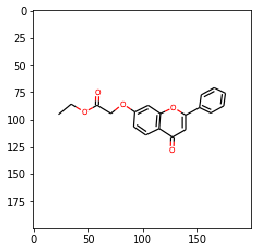

Index: 9
Name: 614-00-6


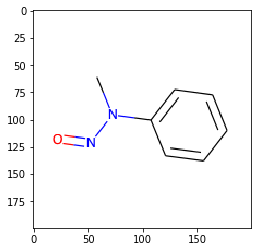

Index: 10
Name: 77996-03-3


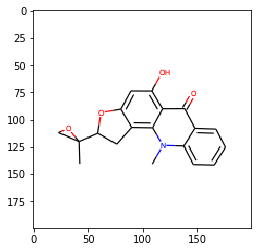

Index: 11
Name: 123-01-3


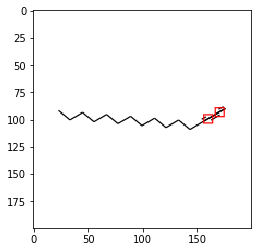

Index: 12
Name: 53478-38-9


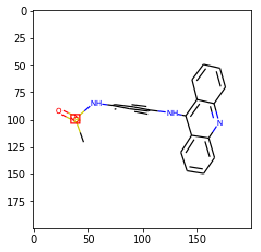

Index: 13
Name: 1836-75-5


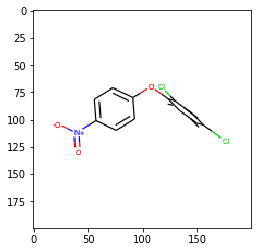

Index: 14
Name: 329-71-5


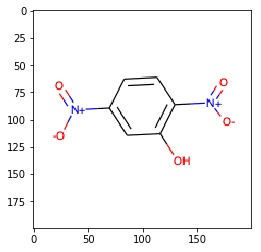

Index: 15
Name: 108-64-5


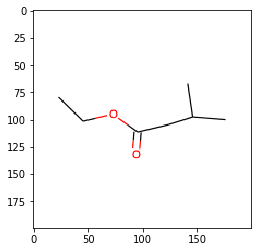

Index: 16
Name: 146177-59-5


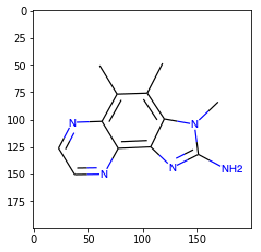

Index: 17
Name: 106264-79-3


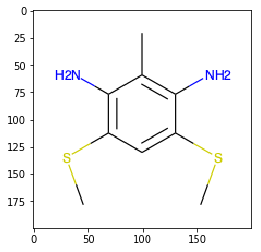

Index: 18
Name: 88488-97-5


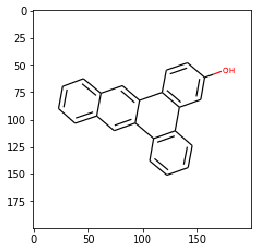

Index: 19
Name: 61203-01-8


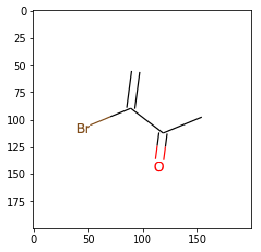

Index: 20
Name: 112-24-3


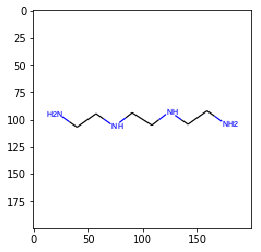

Index: 21
Name: 2849-98-1


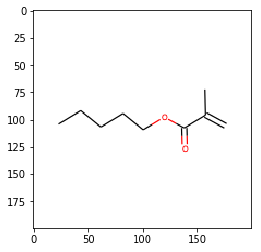

Index: 22
Name: 16423-19-1


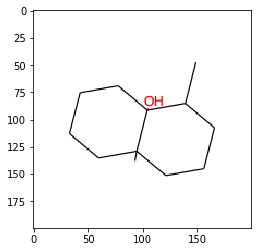

Index: 23
Name: 97-90-5


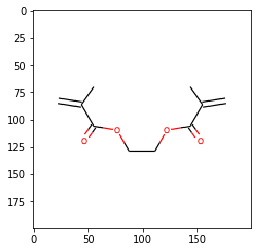

Index: 24
Name: 50438-75-0


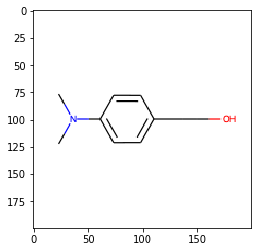

Index: 25
Name: 126983-60-6


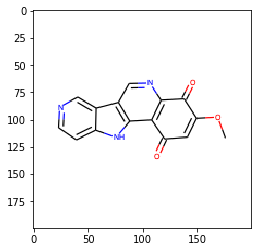

Index: 26
Name: 89-98-5


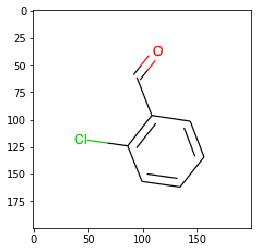

Index: 27
Name: 82-62-2


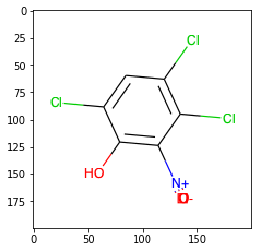

Index: 28
Name: 97606-15-0


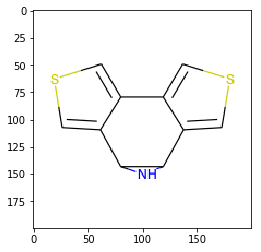

Index: 29
Name: 91-53-2


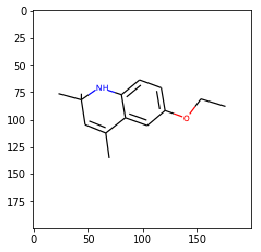

Index: 30
Name: 117-81-7


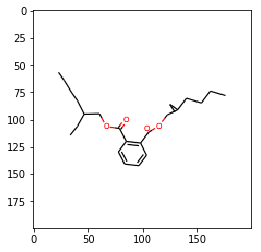

Index: 31
Name: 1928-43-4


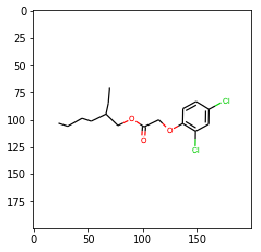

Index: 32
Name: 129927-33-9


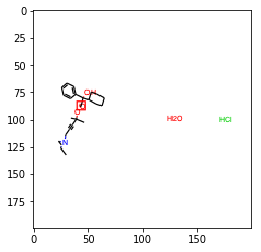

Index: 33
Name: 4513-36-4


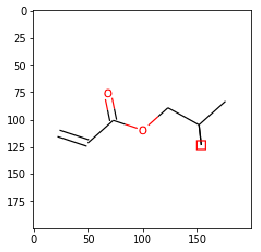

Index: 34
Name: 507-55-1


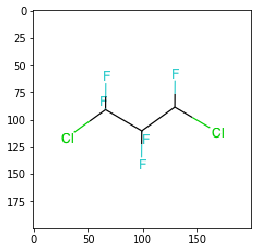

Index: 35
Name: 5042-54-6


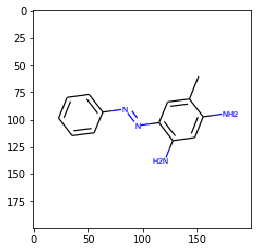

Index: 36
Name: 396-01-0


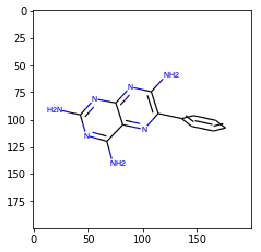

Index: 37
Name: 120-61-6


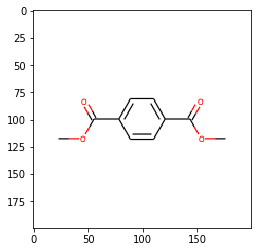

Index: 38
Name: 952-23-8


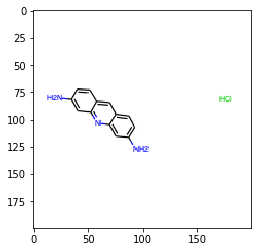

Index: 39
Name: 3807-77-0


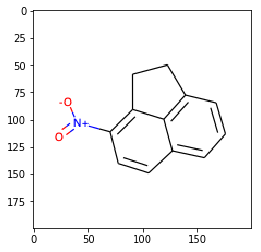

Index: 40
Name: 612-59-9


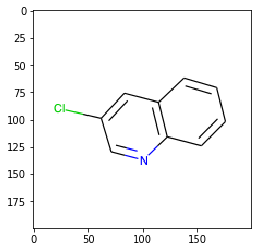

Index: 41
Name: 13675-34-8


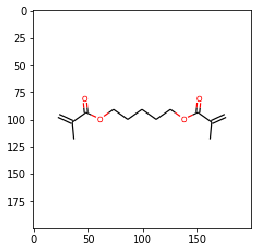

Index: 42
Name: 71628-96-1


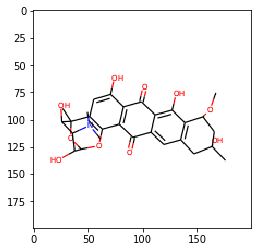

Index: 43
Name: 4629-58-7


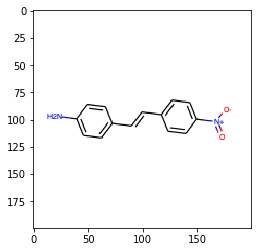

Index: 44
Name: 142438-73-1


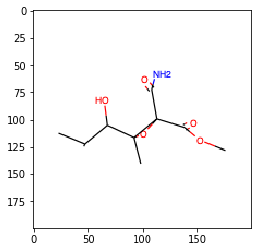

Index: 45
Name: 500-38-9


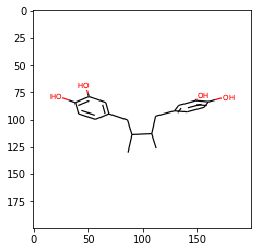

Index: 46
Name: 97-24-5


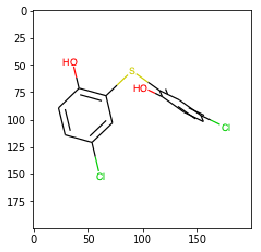

Index: 47
Name: 5634-39-9


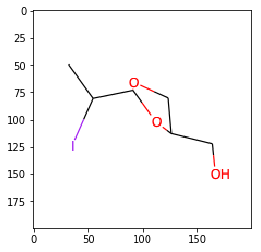

Index: 48
Name: 93-68-5


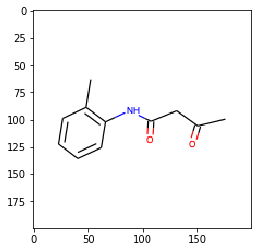

Index: 49
Name: 109-99-9


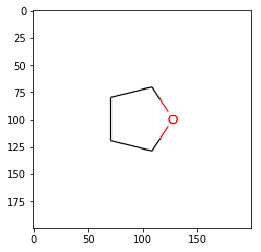

Index: 50
Name: 88133-11-3


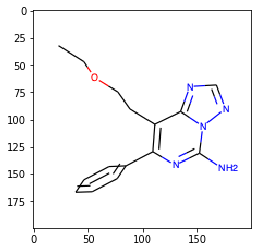

In [26]:
from rdkit.Chem import Draw
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

for i in range(50):
    print("Index:", i+1)
    print("Name:", supplier[i].GetProp("_Name"))
    img = Draw.MolToImage(supplier[i], size=(200, 200))
    plt.imshow(np.array(img))
    plt.show()

# Calculating Morgan fingerprints

Let's move to another work right now by trying to convert the molecules to bits using the Morgan fingerprints algorithm. The algorithm was also briefly described in the [project report](doc/project_report.pdf), if you would like to cover the theory. We're going to go trough two steps:<br>

First, we'll obtain the training samples, which are going to be the bits value returned by the function `AllChem.GetMorganFingerprintAsBitVect`. This is typically the output of calculating the morgan fingerprints for each molecule. Please refer to the subsection [**Explaining bits from Morgan Fingerprints**](https://www.rdkit.org/docs/GettingStartedInPython.html#explaining-bits-from-morgan-fingerprints) from Rdkit to understand the output.

> **\_\_TASK\_\_:** for each molecule calculate MorganFingerprints (with radius <b>3</b>) and size **~2048** (rdkit has also a nice easy function for that)

> <font style="font-family: chalkboard; font-size:11pt; font-style:italic"> Why did we use these specific parameters during the calculation of the fingerprints?</font>

It's really crucial that we save all the `info` dictionaries now so that we can reconstruct the fingerprints later.

In [27]:
import numpy as np
from rdkit.Chem import AllChem
infos = [{} for mol in supplier]
# info = {} # will be mutated in the next function
## calculate the Morgan Fingerprints for every molecule in the supplier with radius 3 and nBits 2048
fingerprints = np.array([AllChem.GetMorganFingerprintAsBitVect(supplier[i], 3, nBits=2048, bitInfo=infos[i]) 
                         for i in range(len(supplier))])
infos = np.array(infos)
print(fingerprints.shape)
print(infos.shape)

(4337, 2048)
(4337,)


Now we have the array `infos` where every element in this array is a dictionary that correspons to one molecule in the dataset.

And there we go. Now that we have successfully extracted the fingerprints that are ready to be passed to the model. Let's move to preparing the training and validation data.
<br>

## Training And Validation Samples

In the following I am gooing split the samples we have into training samples `X_train` and validation samples `X_valid`. Because the validation split was selected randomly (to us), and because amples in the validation set are not supposed to appear in the training set, we will subset the fingerprints manually.

*I'll be using the alias*
* *`valid`, for anything related to the validation set*
* *`train`, for anything related to the training set*
* *`test`, for anything related to the test set <br>
in order to avoid lengthy variable names.*

In [28]:
valid_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335
]

X_train = []
X_valid = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid.append(fingerprints[i])
    else:
        X_train.append(fingerprints[i])
X_train = np.array(X_train)
X_valid = np.array(X_valid)
print(X_train.shape)
print(X_valid.shape)

(4010, 2048)
(327, 2048)


## Training And Validation Labels

Now that we've got the the bits for both the training samples as well as for the validation samples ready, we still have one last thing to do before we start building the model: extract the labels to have a target for our predictions.

The property that we want to extract out of the list, is whether or not the 'Ames test Categorisation' is a mutagen.

* 1 for mutagen 
* 0 for nonmutagen

In [29]:
## Collecting the lables from the dataset
y_train, y_valid, i = [], [], 0
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        if i in valid_ids:
            y_valid.append(1)
        else:
            y_train.append(1)
    else:
        if i in valid_ids:
            y_valid.append(0)
        else:
            y_train.append(0)
    i+=1
    
y_train = np.array(y_train)
y_valid = np.array(y_valid)
print(y_train.shape)
print(y_valid.shape)

(4010,)
(327,)


### Standard Scaling

Finally we have everything ready to pass to the model.
However, the last step in preparing data is to apply Standard Scaling, because the model learns best on standarized data.

In [30]:
from sklearn.preprocessing import StandardScaler
#Scale fingerprints to unit variance and zero mean
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_valid = ss.transform(X_valid)

/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Model's Architecture

From before we know that our data shape is $(4337, 2048)$, which means that the first layer in our model expects an input size of $2048$.<br>
The following layers, on the other hand, can deduce their input size from the previous layer. For instance, the output size of the first layer in my model is 5, beginning with the second layer, I don't need to specify the input size, because the layer can deduce that alone.

In [31]:
# importing all libraries that we'd need
from keras import backend
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam, SGD, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

## for Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from time import time # for timing training

Using TensorFlow backend.


In [32]:
## The initial model
backend.clear_session()
model = Sequential()
model.add(Dense(units=5, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9))
t0=time()
model.fit(X_train, y_train, batch_size=100, epochs=10)
print("Training took ", time()-t0, " sec")
auc = roc_auc_score(y_valid, model.predict(X_valid))
print("with AUC = ", auc)

Epoch 1/10
4010/4010 [==============================] - 0s 90us/step - loss: 0.6544
Epoch 2/10
4010/4010 [==============================] - 0s 17us/step - loss: 0.3345
Epoch 3/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.2449
Epoch 4/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.1876
Epoch 5/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.1453
Epoch 6/10
4010/4010 [==============================] - 0s 17us/step - loss: 0.1182
Epoch 7/10
4010/4010 [==============================] - 0s 18us/step - loss: 0.1020
Epoch 8/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.0863
Epoch 9/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.0759
Epoch 10/10
4010/4010 [==============================] - 0s 16us/step - loss: 0.0681
Training took  1.1808891296386719  sec
with AUC =  0.8647165670173314


# Grid Search

Neural Networks are notoriously difficult to configure and there are a lot of parameters that need to be set. Above all this, it's a very slow process to train and evaulate every model you build. Therefore, one can use optimization methods that allow faster hyperparameters substitution. Using these methods, we can acheive an automated optimization process.<br>
Specifically, I'll be using the grid search method, since Keras library has a plenty of grid-search capable functions.

Keras models can be used by wrapping them with the KerasClassifier. To use these wrappers we must define a function that creates and returns your Keras sequential model, then pass this function to the `build_fn` argument when constructing the KerasClassifier class.<br>
The constructor for the KerasClassifier class can take default arguments that are passed on to the calls to `model.fit()`, such as the number of epochs and the batch size.<br>
The constructor for the KerasClassifier class can also take newly specified arguments that can be passed to your custom `create_model()` function. These new arguments must also be defined in the signature of your `create_model()` function with default parameters.

We use average accuracy as an estimate for out-of-sample accuracy 

<font style="font-family: chalkboard; font-size:11pt;">  Run the following cell, in case you don't want to recalculate the data</font>

By understanding to which case each parameter can be applied, I made a more informative approach in the second training model, with significantly larger architecture.

In [33]:
import pandas as pd
import numpy as np
import csv
from itertools import product
import re
from datetime import datetime

class GridSearch:
    
    def __init__(self, search_space):
        self.search_space = search_space
        self.X_train = None
        self.X_valid = None
        self.y_train = None
        self.y_valid = None
        
        self.index = 0
        self.best_classifier = None
        self.best_auc = None
        self.best_params = None
        self.search_history = None
        self.log_file = None
        self.csv_writer = None
        
    def new_classifier(self, hp_dict):
        """
        Wrapped function that takes hyperparametrs as input and 
        returns a desired Keras sequential model for every new permutation in the Grid Search
        
        Params:
        -------
        hp_dict:
            (dict) the dictionary of hyperparameters, where the values lone candiate values of the search Not the full set of values.
            
        Returns:
        -------
        classifier:
            Keras Sequential model
        """
        backend.clear_session()
        classifier = Sequential()
        classifier.add(Dense(units=hp_dict['units'], input_dim=self.X_train.shape[1], activation=hp_dict['activation']),
                       kernel_initializer=hp_dict['init'])
        ## Create an arbitrary number of Hidden Layers
        for n in range(hp_dict['n_layers']):
            classifier.add(Dense(units=hp_dict['units'], activation=hp_dict['activation']))
            classifier.add(Dropout(hp_dict['dropout']))
        ## Output Layer
        classifier.add(Dense(units=1, activation='sigmoid'))
        ## Compile the model
        classifier.compile(loss='binary_crossentropy',
                           optimizer=hp_dict['optimizer'](lr=hp_dict['lr'], momentum=hp_dict['momentum']),
                           metrics=['accuracy'])

        return classifier
    
    def prepare_permutations(self):
        hp_permuations = product(self.search_space['units'],
                            self.search_space['activation'],
                            self.search_space['optimizer'],
                            self.search_space['lr'],
                            self.search_space['n_layers'],
                            self.search_space['epochs'] ,
                            self.search_space['batch_size'] ,
                            self.search_space['momentum'],
                            self.search_space['init'],
                            self.search_space['dropout_rate']
                          )
        ## Initialize the parameters history both dataframe and log_file
        columns = ['units', 'activation', 'optimizer', 'lr', 'n_layers', 'epochs', 'batch_size', 
                   'momentum', 'init', 'dropout_rate']
        index = [i for i in range(np.prod([len(dim) for dim in self.search_space]))]
        self.search_history = pd.DataFrame(index=index, columns=columns)
        self.log_file = open('search_history.csv', 'w')
        self.csv_writer = csv.writer(self.log_file, delimiter=',')
        self.csv_writer.writerow(columns)
                    
        return hp_permuations
    
    def logSearchHistory(self, permute, auc):
        row = list(permute).append(auc)
        ## change the optimizer's name
        for name in self.search_space['optimizer']:
            optim_name = re.findall(name, row[2])[0]
        row[2] = optim_name
        self.index+=1
        row = [self.index] + row
        self.search_history.append(row)
        self.csv_writer.writerow(row)
        
        
    def search(self, X_train, y_trian, X_valid, y_valid):
        ## assigning class fields
        self.X_train, self.y_train, self.X_valid, self.y_valid = X_train, y_train, X_valid, y_valid
        ## Start logging to file
        
        hp_permuations = self.prepare_permutations()
        
        t_start = datetime.now()
        for permute in hp_permuations:
            hp_dict = {'units': permute[0],
                'activation': permute[1],
                'optimizer': permute[2],
                'lr': permute[3],
                'n_layers': permute[4],
                'epochs': permute[5],
                'batch_size': permute[6] ,
                'momentum': permute[7],
                'init': permute[8],
                'dropout_rate': permute[9]
              }
            classifier = self.new_classifier(hp_dict)
            classifier.fit(X_train, y_train)
            auc =  roc_auc_score(y_valid, classifier.predict(X_valid))
            if auc > self.best_auc:
                self.best_auc = auc
                self.best_params = permute
                self.best_classifier = classifier
            self.logSearchHistory(permute, auc)
            
        self.log_file.close()
        print("Search took ", datetime.now()-t_start)
        return self.best_classifier, self.best_auc, self.best_params, self.search_history

------

In [34]:
search_space = {'units': [512, 1024, 2048],
                'activation': ['relu', 'sigmoid', 'selu'],
                'optimizer': [SGD, Adam],
                'lr': [0.00001, 0.001, 0.2],
                'n_layers': [2, 5, 9],
                'epochs': [10],
                'batch_size': [50, 100],
                'momentum': [0.2, 0.6],
                'init': ['lecun_uniform'],
                'dropout_rate': [0.1]
               }

In [12]:
# search_space = {'units': [512, 1024, 2048],
#                 'activation': ['relu', 'sigmoid', 'selu'],
#                 'optimizer': [SGD, Adam],
#                 'lr': [0.00001, 0.001, 0.1, 0.2],
#                 'n_layers': [2, 5, 9],
#                 'epochs': [10],
#                 'batch_size': [50, 100, 200],
#                 'momentum': [0.2, 0.6],
#                 'init': ['lecun_uniform', 'normal'],
#                 'dropout_rate': [0.1, 0.5]
#                }
gs = GridSearch(search_space)
## Fix random seed for reproducibility
seed = 7
np.random.seed(seed)
best_classifier, best_auc, best_params, search_history = gs.search(X_train, y_train, X_valid, y_valid)

KeyboardInterrupt: 

In [35]:
hp_permuations = product(search_space['units'],
                    search_space['activation'],
                    search_space['optimizer'],
                    search_space['lr'],
                    search_space['n_layers'],
                    search_space['epochs'] ,
                    search_space['batch_size'] ,
                    search_space['momentum'],
                    search_space['init'],
                    search_space['dropout_rate']
              )

In [ ]:
## the folloing function requires that the output file is open
f = open("Grid_Search_Ouput.txt", "w")
def estimateTime():
    """
    Custom function that estimates the time that a grid search will take depending on the
    number of permutations.
    """
    product = 1
    for hyperparameter in hyperparameters:
        print(len(hyperparameter))
        product = product * len(hyperparameter)
    message = "Number of iterations: {}".format(product)
    print(message)
    f.write(message)
    total_seconds = product * 6
    h = str(total_seconds//3600)
    remainder = float('.'+str(total_seconds/3600).split('.')[1])
    m = str(format(60 * remainder, '.8f')).split('.')[0]
    remainder = float(str(format(60 * remainder, '.8f')).split('.')[1])
    s = str(format(remainder * 60, '.8f')).split('.')[0]
    message = "Estimated time: {}h:{}m:{}s\n\n".format(h, m, s)
    print(message)
    f.write(message)

# Reconstructing the best Model

Now we're gonna reconstruct the best-scoring model found by our grid Search and re-train it and evalute. We want to see how big of an influence can the initialization have on the model's score. Later, you'll see that it's actually a significant difference ($0.03$ in terms of AUC).

In [36]:
## The serious model
from time import time
backend.clear_session()
classifier = Sequential()
classifier.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
for i in range(5):
    classifier.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dropout(rate=0.1))
## output layer
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
t_start = datetime.now()
classifier.fit(X_train, y_train, batch_size=100, epochs=10)
print("Model finished training in ", datetime.now() - t_start)

Epoch 1/10
4010/4010 [==============================] - 2s 386us/step - loss: 0.7944 - acc: 0.5257
Epoch 2/10
4010/4010 [==============================] - 1s 268us/step - loss: 0.7097 - acc: 0.5536
Epoch 3/10
4010/4010 [==============================] - 1s 273us/step - loss: 0.6572 - acc: 0.6182
Epoch 4/10
4010/4010 [==============================] - 1s 257us/step - loss: 0.6217 - acc: 0.6491
Epoch 5/10
4010/4010 [==============================] - 1s 267us/step - loss: 0.5775 - acc: 0.6905
Epoch 6/10
4010/4010 [==============================] - 1s 267us/step - loss: 0.5553 - acc: 0.7110
Epoch 7/10
4010/4010 [==============================] - 1s 269us/step - loss: 0.5010 - acc: 0.7561
Epoch 8/10
4010/4010 [==============================] - 1s 260us/step - loss: 0.4462 - acc: 0.7873
Epoch 9/10
4010/4010 [==============================] - 1s 252us/step - loss: 0.4148 - acc: 0.8095
Epoch 10/10
4010/4010 [==============================] - 1s 320us/step - loss: 0.3599 - acc: 0.8449
Model fin

In [37]:
y_prob = classifier.predict(X_valid)
y_pred= classifier.predict_classes(X_valid)

auc = roc_auc_score(y_valid, y_prob)
print("With AUC ", auc)

With AUC  0.7819571633996821


## The ROC Curve

As another means for evaluating the best model's performance let's plot the ROC curve

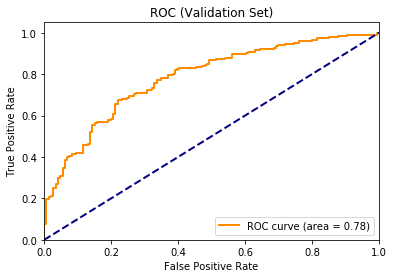

In [38]:
%matplotlib inline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
def plot_roc(fpr, tpr, thresholds, title):
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
plot_roc(fpr, tpr, thresholds, title='ROC (Validation Set)')

In the previous model we use ....,.... and got a $0.743$ auc score, which is relatively a good score. However, we'd still need to see what parameters play the biggest role in order for this model to learn. i.e. what parameters have biggest influence on updating the weights of this model. By doing so, we are also able to understand more about the data.

<br>

# Prediction Analysis

Let's now together examine the success of this model's predictions.<br>
Because the type of classificaiton is *binary*. i.e. the output is either $0$ or $1$ ('nonmutagen' or 'mutagen'), unlike in *multilabel classification* where the output can any float value ranging from $0$ to $1$, we can use a confusion matrix which shows true postives with respect to false postives, and true negatives with respect to false negatives - more on that in the following [**remark on Confusion Matrix**](Reading_sdf_file.ipynb#Remark-on-Confusion-Matrix).<br>

Confusion matrix, without normalization
[[ 64  82]
 [ 21 160]]


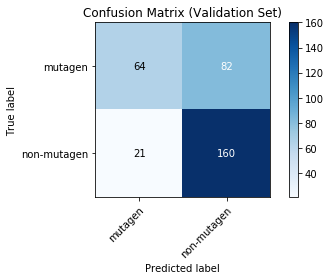

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
classes = np.array(['mutagen', 'non-mutagen'])
plot_confusion_matrix(y_valid, y_pred, classes=classes, title='Confusion Matrix (Validation Set)')

In [40]:
## define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
#              'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh',
#               'sigmoid', 'hard_sigmoid']
# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# neurons = [5, 10, 20, 50, 100, 200, 256, 512, 2048]

# Test Set

Now we won't to omit any chance of random prediction, therefore we're gonna predict on a test set. First thing to do is to load the test set as we did earlier

In [41]:
#### Read Test data ####
X_test = []
y_test = []
info={}
f = open('data/test.csv', 'r')
csv_reader = csv.reader(f)
next(csv_reader, None)  # skip the headers
for row in csv_reader:
    mol = Chem.MolFromSmiles(row[1])
    ## Calculate fingerprint accordingly
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048, bitInfo=info)
    ## Append fp into fingerprints
    X_test.append(fp)
    y_test.append(int(row[2]))
f.close()

In [42]:
## Apply standard scaling
X_test = ss.transform(np.array(X_test))
y_test = np.array(y_test)

/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
## fix random seed for reproducibility
seed = 7
np.random.seed(seed)
y_prob = classifier.predict(X_test)
y_pred = classifier.predict_classes(X_test)
auc = roc_auc_score(y_test, y_prob)
print("Test AUC = ", auc)

Test AUC =  0.7538714610832954


We will also plot the ROC curve and confusion matrix of the test set.

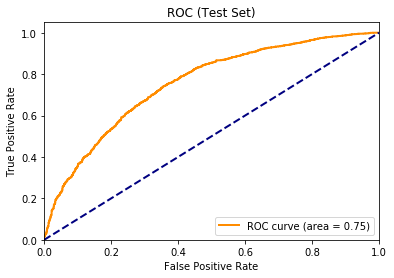

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc(fpr, tpr, thresholds, title="ROC (Test Set)")

Confusion matrix, without normalization
[[ 706  919]
 [ 199 1491]]


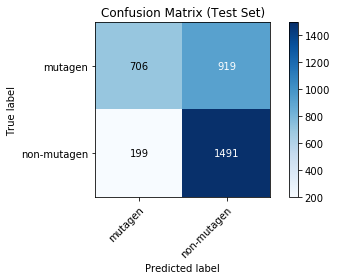

In [45]:
classes = np.array(['mutagen', 'non-mutagen'])
plot_confusion_matrix(y_test, y_pred, classes=classes, title="Confusion Matrix (Test Set)")

## Train on non-normalized data!

Here I wanna test if I can train on unormalized data. I won't do the same to `y`, because we can still use the same labels from before.

**ATTENTION**: don't clear the session this time because we want to keep both models in the backend.

In [46]:
## Append bit vectors of without normalizing it
X_train_un = []
X_valid_un = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid_un.append(fingerprints[i])
    else:
        X_train_un.append(fingerprints[i])
X_train_un = np.array(X_train_un)
X_valid_un = np.array(X_valid_un)
print(X_train_un.shape)
print(X_valid_un.shape)

(4010, 2048)
(327, 2048)


Epoch 1/10
4010/4010 [==============================] - 2s 432us/step - loss: 0.6871 - acc: 0.5349
Epoch 2/10
4010/4010 [==============================] - 1s 307us/step - loss: 0.6789 - acc: 0.5618
Epoch 3/10
4010/4010 [==============================] - 1s 282us/step - loss: 0.6722 - acc: 0.5658
Epoch 4/10
4010/4010 [==============================] - 1s 268us/step - loss: 0.6644 - acc: 0.5805
Epoch 5/10
4010/4010 [==============================] - 1s 255us/step - loss: 0.6539 - acc: 0.6035
Epoch 6/10
4010/4010 [==============================] - 1s 268us/step - loss: 0.6397 - acc: 0.6274
Epoch 7/10
4010/4010 [==============================] - 1s 324us/step - loss: 0.6226 - acc: 0.6556
Epoch 8/10
4010/4010 [==============================] - 2s 417us/step - loss: 0.5999 - acc: 0.6805
Epoch 9/10
4010/4010 [==============================] - 1s 326us/step - loss: 0.5795 - acc: 0.6960
Epoch 10/10
4010/4010 [==============================] - 1s 283us/step - loss: 0.5591 - acc: 0.7212
Model fin

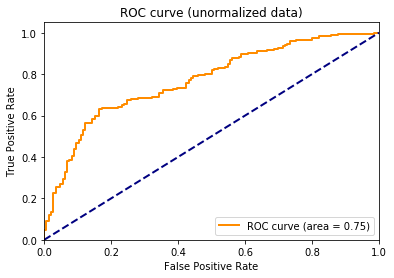

In [47]:
## Build classifier_2 02
from time import time
classifier_2 = Sequential()
classifier_2.add(Dense(512, input_dim=X_train_un.shape[1], activation='relu', kernel_initializer='he_uniform'))
for i in range(5):
    classifier_2.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    classifier_2.add(Dropout(rate=0.1))
## output layer
classifier_2.add(Dense(units=1, activation='sigmoid'))
classifier_2.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
t_start = datetime.now()

## train
classifier_2.fit(X_train_un, y_train, batch_size=100, epochs=10)
print("Model finished training in ", datetime.now() - t_start)

y_prob_un = classifier_2.predict(X_valid_un)
y_pred_un = classifier_2.predict_classes(X_valid_un)
auc_un = roc_auc_score(y_valid, y_pred_un)
print("Model scores AUC: ", auc_un)
fpr_un, tpr_un, thresholds_un = roc_curve(y_valid, y_prob_un)
%matplotlib inline
plot_roc(fpr_un, tpr_un, thresholds_un, title="ROC curve (unormalized data)");

So over here we see that not normalizing the data would actually lead to severe drop inthe AUC score, and the learning would not be as fast either.

# Reconstructing the Environments from Bits

First things first, we need to see that we obtain back the fingerprints so that we can visualize the attributions of each atom in the substructure. This process is also known as reconstructing the environment.

> The dictionary provided is populated with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples.

Define the following function so that we can draw the fingerprints

In [48]:
from IPython.display import SVG, display
%matplotlib inline
def display_mol(svg_str):
    """function to display the Morgan fingeprints when SVGs are returned
    @Parms:
        svg_str: and svg string represented in XML format, or file, or URL
    """
    display(SVG(svg_str))

To print full `numpy` arrays instead of just edges.

In [50]:
import sys
np.set_printoptions(threshold=sys.maxsize)

### Visualizing the Fingerprints

Over here, we draw all fingerprints found in the first molecule. ATTENTION: we print only the first example of the fingerprint, in case they were several examples.

Adding the argument `which_example`  select within the tuples of one single fingerprint, just shows the fingerprint from the perspective of a different central atom. But the fingerprint looks essentially the same.

Index: 1
bit Id: 47 Examples: ((6, 3),)


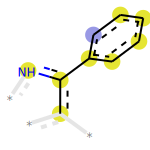

Index: 2
bit Id: 119 Examples: ((3, 2),)


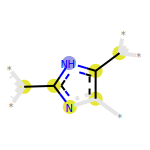

Index: 3
bit Id: 155 Examples: ((0, 1),)


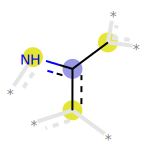

Index: 4
bit Id: 305 Examples: ((13, 3),)


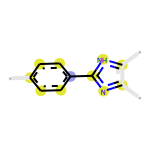

Index: 5
bit Id: 322 Examples: ((22, 1),)


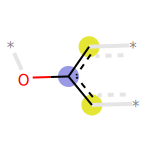

Index: 6
bit Id: 323 Examples: ((1, 1),)


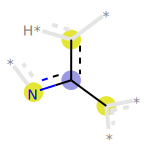

Index: 7
bit Id: 371 Examples: ((20, 3),)


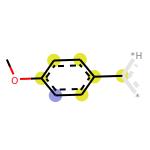

Index: 8
bit Id: 378 Examples: ((5, 0),)


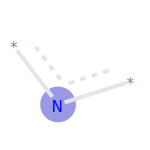

Index: 9
bit Id: 389 Examples: ((16, 2), (19, 2))


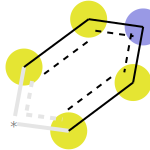

Index: 10
bit Id: 434 Examples: ((5, 3),)


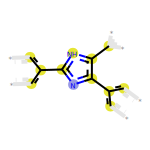

Index: 11
bit Id: 471 Examples: ((4, 2),)


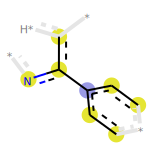

Index: 12
bit Id: 498 Examples: ((11, 3), (14, 3))


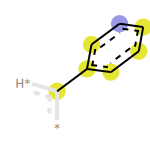

Index: 13
bit Id: 507 Examples: ((0, 3),)


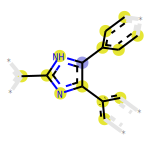

Index: 14
bit Id: 566 Examples: ((3, 3),)


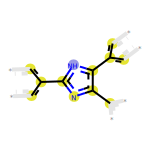

Index: 15
bit Id: 661 Examples: ((2, 2),)


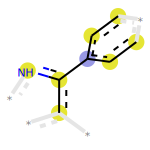

Index: 16
bit Id: 695 Examples: ((23, 0),)


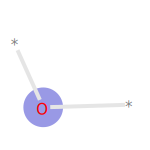

Index: 17
bit Id: 718 Examples: ((20, 2), (21, 2))


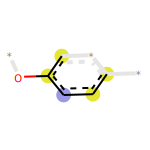

Index: 18
bit Id: 736 Examples: ((6, 2), (9, 2), (7, 2), (10, 2))


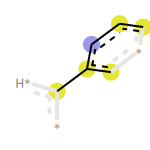

Index: 19
bit Id: 781 Examples: ((23, 2),)


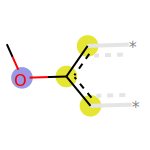

Index: 20
bit Id: 798 Examples: ((0, 2),)


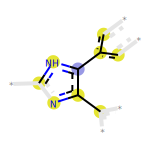

Index: 21
bit Id: 831 Examples: ((22, 2),)


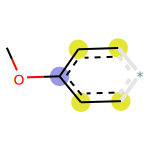

Index: 22
bit Id: 840 Examples: ((1, 3),)


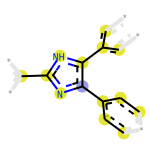

Index: 23
bit Id: 841 Examples: ((24, 1),)


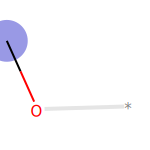

Index: 24
bit Id: 859 Examples: ((2, 3),)


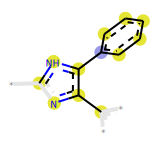

Index: 25
bit Id: 896 Examples: ((17, 2), (18, 2))


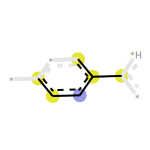

Index: 26
bit Id: 1057 Examples: ((24, 0),)


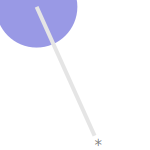

Index: 27
bit Id: 1088 Examples: ((11, 1), (14, 1), (12, 1), (16, 1), (15, 1), (19, 1))


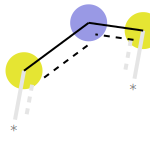

Index: 28
bit Id: 1114 Examples: ((3, 0),)


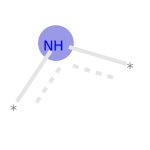

Index: 29
bit Id: 1160 Examples: ((2, 1), (4, 1), (13, 1))


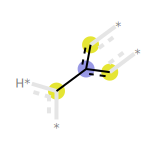

Index: 30
bit Id: 1199 Examples: ((11, 2), (12, 2), (14, 2), (15, 2))


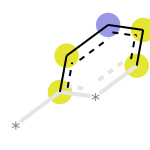

Index: 31
bit Id: 1218 Examples: ((5, 2),)


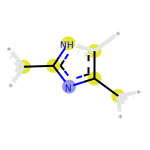

Index: 32
bit Id: 1322 Examples: ((4, 3),)


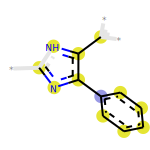

Index: 33
bit Id: 1380 Examples: ((0, 0), (1, 0), (2, 0), (4, 0), (8, 0), (13, 0), (22, 0))


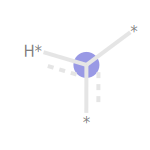

Index: 34
bit Id: 1454 Examples: ((8, 2),)


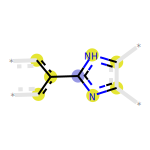

Index: 35
bit Id: 1472 Examples: ((1, 2),)


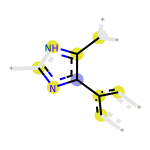

Index: 36
bit Id: 1523 Examples: ((17, 3),)


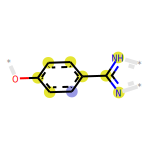

Index: 37
bit Id: 1536 Examples: ((23, 1),)


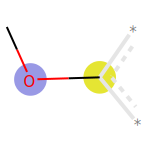

Index: 38
bit Id: 1609 Examples: ((8, 1),)


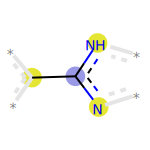

Index: 39
bit Id: 1698 Examples: ((13, 2),)


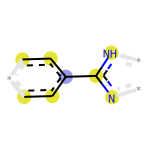

Index: 40
bit Id: 1745 Examples: ((3, 1),)


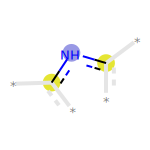

Index: 41
bit Id: 1750 Examples: ((6, 1), (7, 1), (9, 1), (10, 1), (17, 1), (18, 1), (20, 1), (21, 1))


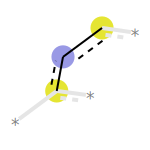

Index: 42
bit Id: 1831 Examples: ((8, 3),)


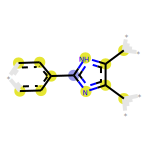

Index: 43
bit Id: 1855 Examples: ((5, 1),)


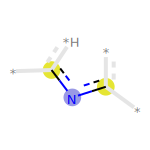

Index: 44
bit Id: 1873 Examples: ((6, 0), (7, 0), (9, 0), (10, 0), (11, 0), (12, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0))


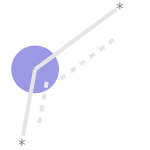

Index: 45
bit Id: 1947 Examples: ((16, 3), (19, 3))


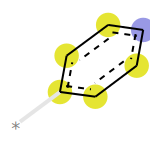

Index: 46
bit Id: 1952 Examples: ((22, 3),)


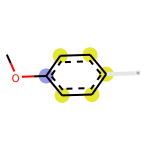

Index: 47
bit Id: 1971 Examples: ((9, 3),)


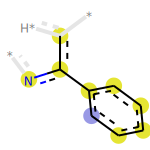

In [58]:
bi_keys = [key for key in infos[0].keys()]
for i in range(len(bi_keys)):
    print("Index:", i+1)
    print("bit Id:", bi_keys[i], "Examples:", infos[0][bi_keys[i]])
    display_mol(Draw.DrawMorganBit(supplier[0], bi_keys[i], infos[0]))  

Now I woud like to generate a SMILES string for every fingerprint we find in one molecule and then we'll stack this in to one matrix of size ($4337$ mols, $2048$ bits). Because each bits indicates the presence of a fingerprint and 0 represents the abscense of any fingerprints, we will obtain empty string where bits are $0$.

And then “explain” the bit by generating SMILES for that submolecule:

In [78]:
#### EXPERIMENTAL ####
j = 0
for i in range(len(fingerprints[0])):
    if fingerprints[0][i] != 0:
        print(i, bi_keys[j])
        j+=1

47 47
119 119
155 155
305 305
322 322
323 323
371 371
378 378
389 389
434 434
471 471
498 498
507 507
566 566
661 661
695 695
718 718
736 736
781 781
798 798
831 831
840 840
841 841
859 859
896 896
1057 1057
1088 1088
1114 1114
1160 1160
1199 1199
1218 1218
1322 1322
1380 1380
1454 1454
1472 1472
1523 1523
1536 1536
1609 1609
1698 1698
1745 1745
1750 1750
1831 1831
1855 1855
1873 1873
1947 1947
1952 1952
1971 1971


In [96]:
## Creates a string matrix of shape (4337, 2048)
amaps = []
fingerprints_smiles = np.zeros(fingerprints.shape, str)
for i in range(fingerprints.shape[0]):
    for key in infos[i].keys():
        env = Chem.FindAtomEnvironmentOfRadiusN(supplier[i], infos[i][key][0][1], infos[i][key][0][0]) # radius, atom
    #                                                             [mol_id][fp_id][example_id][radius/ atom]
        amap = {}
        submol = Chem.PathToSubmol(supplier[i], env, atomMap=amap)
        amaps.append(amap)
        fingerprints_smiles[i, key] = Chem.MolToSmiles(submol)
    # print("Number of atoms:", submol.GetNumAtoms())
    # ## atomic map
    # print(amap)
    # print("Submolecules smiles:\n", Chem.MolToSmiles(submol))

6

### Stacking bit Vector and Attribution Vector vertically

Here we stack the bits next to thei\r attribution values.

In [166]:
np.vstack((fingerprints[0], integrated_gradients[0])).T

array([[ 0.00000000e+00, -6.09406738e-06],
       [ 0.00000000e+00, -5.14728954e-04],
       [ 0.00000000e+00,  1.08308211e-04],
       [ 0.00000000e+00, -1.37902855e-05],
       [ 0.00000000e+00,  1.08946381e-03],
       [ 0.00000000e+00, -3.01402911e-04],
       [ 0.00000000e+00,  4.81156876e-04],
       [ 0.00000000e+00,  1.86775570e-04],
       [ 0.00000000e+00, -2.71809216e-04],
       [ 0.00000000e+00,  3.27352368e-05],
       [ 0.00000000e+00,  1.64398964e-04],
       [ 0.00000000e+00, -2.56209260e-04],
       [ 0.00000000e+00, -1.36496691e-04],
       [ 0.00000000e+00, -4.70327865e-04],
       [ 0.00000000e+00, -2.46694203e-04],
       [ 0.00000000e+00, -3.38789481e-04],
       [ 0.00000000e+00, -2.99672333e-04],
       [ 0.00000000e+00,  5.17721437e-05],
       [ 0.00000000e+00, -6.27514464e-04],
       [ 0.00000000e+00, -1.31118455e-04],
       [ 0.00000000e+00,  6.58545712e-05],
       [ 0.00000000e+00, -1.52775064e-04],
       [ 0.00000000e+00,  1.12277667e-05],
       [ 0.

The following cell has shown that `DrawMorganEnv` is just a returned instance of the funrction `DrawMorganBit`.

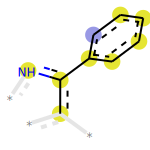

In [110]:
##### INSIGNIFICANT #####
display_mol(Draw.DrawMorganEnv(supplier[0], 6, 3, molSize=(150, 150), baseRad=0.3, useSVG=True,
                               aromaticColor=(0.9, 0.9, 0.2), ringColor=(0.8, 0.8, 0.8),
                               centerColor=(0.6, 0.6, 0.9), extraColor=(0.9, 0.9, 0.9)))

# Integrated Gradients

Here we will enter a new chapter we're trying to identify the exact structures to which we can attribute's the model's decision. The model was recognizing patterns in the data, but we would like to understand for once, what these patterns are and how they look like chemically.

Let's see if we can convert the bits back to molecules. According to RDkit
> <p style="font-family: helvatica; font-size:11pt;">Bit vectors are containers for efficiently storing a set number of binary values, e.g. for fingerprints. The RDKit includes two types of fingerprints differing in how they store the values internally; the two types are easily interconverted but are best used for different purpose: </p>

In [140]:
import sys
sys.path.append("modules/")
from IntegratedGradients import *
ig = integrated_gradients(classifier)
integrated_gradients = np.array([ig.explain(sample) for sample in X_train])
integrated_gradients.shape

/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


(4010, 2048)

Now we've just calculated the attribution of every features to the outcome. In the following we would like to visualize this. To do this we'll take a random sample and try to explain the difference between the true label and the predicted label.

Often you will not communicate the attribution numbers, but communicate a visualization of the attributions. Take care to choose a good visualization. Bad visualizations can distort the attribution numbers.

In [86]:
# Randomly choose a sample to explain. 
# Get the true label and a prediction associated with it.
index = np.random.randint(3315)
print("Truth     :", np.argmax(y_test[index]))
print("Prediction:", np.argmax(classifier.predict(X_test[index:index+1])[0]))

Truth     : 0
Prediction: 0


In [97]:
def get_color(attr):
    if attr > 0:
        r = int(128*attr) + 127
        g = 128 - int(64*attr)
        b = 128 - int(64*attr) 
    else:
        r = 128 + int(64*attr)
        g = 128 + int(64*attr) 
        b = int(-128*attr) + 127
    return r,g,b

AttributeError: 'tuple' object has no attribute 'shape'

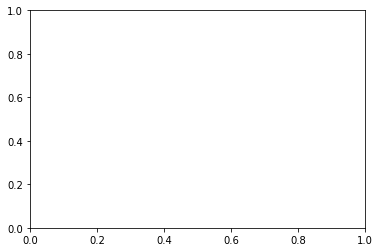

In [104]:
for i in range(integrated_gradients.shape[1]):
    attr = integrated_gradients[0, i]
    r, g, b = get_color(attr)
    plt.scatter(X_train[0, i], attr, c=(r, g, b, .5))
plt.show()

In [113]:
from rdkit.Chem import Draw
m = supplier[0]
AllChem.Compute2DCoords(m)
Draw.MolToFile(m,'images/cdk2_mol1.o.png')

<br><br><br><br><br><br><br>
# Save Data Matrices in Separate Files

The following cell is just in order for me to transfer the bits data to another machine, without having to recalculate them.<br>
The cell is saved in raw format, because I've already run the code. If you'd like to overwrite the files, rerun the cell.

In [12]:
## save data for easy reproduction
np.savetxt("data/train_samples.txt", train_samples , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/train_labels.txt", train_labels , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/valid_samples.txt", valid_samples , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/valid_labels.txt", valid_labels , delimiter=' ', comments='# ', encoding=None)